# Creating Win Prediction Model with Stockfish Scores

This is an exploration into the possibility of using the board strength early into a game to predict whether white or black will win their games.


During this exploration, we will look at the first ten moves made by white and black.

One pitfall of this research is that chess has games that can last as few as 2-4 moves, such as Fool's Mate and Scholar's Mate. For this study we will remove all instances that have fewer than ten moves. 

In [3]:
import pandas as pd
import statistics as stats

# sklearn utility
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import export_text

# sklearn grid search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv("base_chess_data.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores
0,2354,2411,0,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...
1,2523,2460,0,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55
2,1915,1999,-1,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...
3,2446,2191,1,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...
4,2168,2075,1,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...


In [5]:
# add number of moves to each game

game_num_moves = []

for index, row in df.iterrows():
    num_moves_by_both = len(row['Moves'].split(" "))
    num_white_moves = (num_moves_by_both // 2) + (num_moves_by_both % 2 == 1)
    game_num_moves.append(num_white_moves)


df['NumWhiteMoves'] = game_num_moves
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves
0,2354,2411,0,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19
1,2523,2460,0,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7
2,1915,1999,-1,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53
3,2446,2191,1,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39
4,2168,2075,1,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25


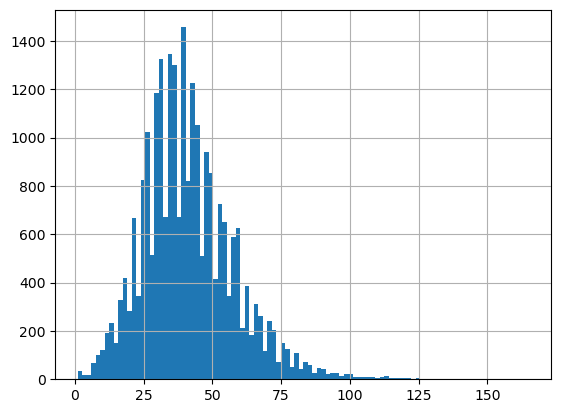

In [6]:
hist = df['NumWhiteMoves'].hist(bins=100)

In [65]:
df_white_wins = pd.value_counts(df.WhiteWins).to_frame().reset_index()
print(df_white_wins)
print(df_white_wins.loc[0]['WhiteWins'] / df.index.size)

   index  WhiteWins
0      1       9665
1     -1       7493
2      0       7487
0.3921687969162102


In [8]:
# remove games from our set that have fewer than 11 white moves

list_to_remove = []
for index, row in df.iterrows():
    if(row['NumWhiteMoves'] <= 10):
        list_to_remove.append(index)

df = df.drop(list_to_remove)

df

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves
0,2354,2411,0,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19
2,1915,1999,-1,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53
3,2446,2191,1,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39
4,2168,2075,1,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25
5,2437,2254,0,Nf3 d5 d4 Nf6 c4 e6 Nc3 Be7 Bg5 h6 Bh4 O-O e3 ...,18 29 10 22 20 18 19 28 24 18 17 16 18 38 48 3...,29
...,...,...,...,...,...,...
24995,1844,2063,-1,e4 d6 d4 Nf6 Nc3 g6 Nf3 Bg7 h3 a6 Bf4 Nc6 Qd2 ...,26 51 59 46 50 70 68 57 37 55 41 43 22 18 -44 ...,65
24996,2391,2513,-1,e4 e6 d4 d5 Nd2 Be7 e5 Nh6 Ndf3 c5 c3 cxd4 cxd...,26 42 43 29 -5 25 15 21 -1 0 3 23 10 10 14 13 ...,34
24997,2634,2541,1,d4 Nf6 c4 e6 Nc3 d5 Nf3 Nbd7 Bf4 dxc4 e3 Nb6 B...,19 23 16 22 28 27 13 31 31 23 23 24 33 32 29 2...,68
24998,2319,2069,1,Nf3 Nf6 c4 g6 g3 Bg7 Bg2 O-O O-O d5 cxd5 Nxd5 ...,18 11 13 47 27 8 17 13 16 21 38 25 6 42 42 31 ...,43


Let's define a "delta" as the change in value in centipawns after a player moves. A positive delta means the move was beneficial for white, and a negative delta means it was beneficial for black. Note that 'beneficial for white' can mean white playing a good move, or black playing a poor move.

To start, let's create a simplistic logistic model that uses the average delta that white and black each create per move, as well as the difference in elo between white and black. Later, we will create different linear combinations of these such as the average of all of white's and black's deltas.

Remember that the average delta will be positive if it makes white more likely to win, and negative if it makes black more likely to win.

In [9]:
# add white's elo over black

elo_differences = []

for index, row in df.iterrows():
    
    elo_differences.append(row["WhiteElo"] - row["BlackElo"])


df['EloDifference'] = elo_differences

df

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,EloDifference
0,2354,2411,0,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,-57
2,1915,1999,-1,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,-84
3,2446,2191,1,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39,255
4,2168,2075,1,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25,93
5,2437,2254,0,Nf3 d5 d4 Nf6 c4 e6 Nc3 Be7 Bg5 h6 Bh4 O-O e3 ...,18 29 10 22 20 18 19 28 24 18 17 16 18 38 48 3...,29,183
...,...,...,...,...,...,...,...
24995,1844,2063,-1,e4 d6 d4 Nf6 Nc3 g6 Nf3 Bg7 h3 a6 Bf4 Nc6 Qd2 ...,26 51 59 46 50 70 68 57 37 55 41 43 22 18 -44 ...,65,-219
24996,2391,2513,-1,e4 e6 d4 d5 Nd2 Be7 e5 Nh6 Ndf3 c5 c3 cxd4 cxd...,26 42 43 29 -5 25 15 21 -1 0 3 23 10 10 14 13 ...,34,-122
24997,2634,2541,1,d4 Nf6 c4 e6 Nc3 d5 Nf3 Nbd7 Bf4 dxc4 e3 Nb6 B...,19 23 16 22 28 27 13 31 31 23 23 24 33 32 29 2...,68,93
24998,2319,2069,1,Nf3 Nf6 c4 g6 g3 Bg7 Bg2 O-O O-O d5 cxd5 Nxd5 ...,18 11 13 47 27 8 17 13 16 21 38 25 6 42 42 31 ...,43,250


In [10]:
# add column for all deltas

# For moves with NA, we assume they have 0 change in the current board strength.

deltas = []

for index, row in df.iterrows():
    
    boardStrengths = row["StockfishScores"].split(" ")
    
    delta_string = ""
    current_board_strength = 0

    for score in boardStrengths:
        if(score == "NA"):
            delta_string += "0 "
            continue

        numeric_score = int(score)
        delta = numeric_score - current_board_strength
        delta_string += str(delta) + " "

        current_board_strength = numeric_score

    delta_string = delta_string[:-1] # remove trailing whitespace
    
    deltas.append(delta_string)


df['StockfishDeltas'] = deltas

df


,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,EloDifference,StockfishDeltas
0,2354,2411,0,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,-57,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...
2,1915,1999,-1,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,-84,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...
3,2446,2191,1,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39,255,2 19 -16 48 -18 10 -8 17 -44 12 -14 40 -18 -13...
4,2168,2075,1,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25,93,26 38 -29 18 -35 2 -2 2 -10 39 11 35 -4 -9 1 1...
5,2437,2254,0,Nf3 d5 d4 Nf6 c4 e6 Nc3 Be7 Bg5 h6 Bh4 O-O e3 ...,18 29 10 22 20 18 19 28 24 18 17 16 18 38 48 3...,29,183,18 11 -19 12 -2 -2 1 9 -4 -6 -1 -1 2 20 10 -11...
...,...,...,...,...,...,...,...,...
24995,1844,2063,-1,e4 d6 d4 Nf6 Nc3 g6 Nf3 Bg7 h3 a6 Bf4 Nc6 Qd2 ...,26 51 59 46 50 70 68 57 37 55 41 43 22 18 -44 ...,65,-219,26 25 8 -13 4 20 -2 -11 -20 18 -14 2 -21 -4 -6...
24996,2391,2513,-1,e4 e6 d4 d5 Nd2 Be7 e5 Nh6 Ndf3 c5 c3 cxd4 cxd...,26 42 43 29 -5 25 15 21 -1 0 3 23 10 10 14 13 ...,34,-122,26 16 1 -14 -34 30 -10 6 -22 1 3 20 -13 0 4 -1...
24997,2634,2541,1,d4 Nf6 c4 e6 Nc3 d5 Nf3 Nbd7 Bf4 dxc4 e3 Nb6 B...,19 23 16 22 28 27 13 31 31 23 23 24 33 32 29 2...,68,93,19 4 -7 6 6 -1 -14 18 0 -8 0 1 9 -1 -3 -4 0 8 ...
24998,2319,2069,1,Nf3 Nf6 c4 g6 g3 Bg7 Bg2 O-O O-O d5 cxd5 Nxd5 ...,18 11 13 47 27 8 17 13 16 21 38 25 6 42 42 31 ...,43,250,18 -7 2 34 -20 -19 9 -4 3 5 17 -13 -19 36 0 -1...


In [11]:
# add columns for the average delta between white and black

average_white_delta = []
average_black_delta = []

for index, row in df.iterrows():
    
    deltas = row["StockfishDeltas"].split(" ")[0:20]
    for i, d in enumerate(deltas):
        deltas[i] = int(d)

    whitedeltas = deltas[0:20:2]
    blackdeltas = deltas[1:20:2]

    average_white_delta.append(stats.mean(whitedeltas))
    average_black_delta.append(stats.mean(blackdeltas))



df['WhiteAverageOpeningDelta'] = average_white_delta
df['BlackAverageOpeningDelta'] = average_black_delta

df.head(2)


,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,EloDifference,StockfishDeltas,WhiteAverageOpeningDelta,BlackAverageOpeningDelta
0,2354,2411,0,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,-57,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...,-1.4,0.4
2,1915,1999,-1,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,-84,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...,-2.0,3.2


# Initial Model and Predictions

First, we build a model to predict whether white will win using the first ten stockfish deltas. We will compare it to a base model which only uses the elos, to see if the stockfish deltas are improving the model.

In [34]:
pred_df = df[["WhiteElo",
              "BlackElo",
              "WhiteWins",
              "NumWhiteMoves",
              "EloDifference",
              "StockfishDeltas",
              "WhiteAverageOpeningDelta",
              "BlackAverageOpeningDelta"]]
pred_df.head()

,WhiteElo,BlackElo,WhiteWins,NumWhiteMoves,EloDifference,StockfishDeltas,WhiteAverageOpeningDelta,BlackAverageOpeningDelta
0,2354,2411,0,19,-57,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...,-1.4,0.4
2,1915,1999,-1,53,-84,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...,-2.0,3.2
3,2446,2191,1,39,255,2 19 -16 48 -18 10 -8 17 -44 12 -14 40 -18 -13...,-18.5,21.6
4,2168,2075,1,25,93,26 38 -29 18 -35 2 -2 2 -10 39 11 35 -4 -9 1 1...,-3.8,18.0
5,2437,2254,0,29,183,18 11 -19 12 -2 -2 1 9 -4 -6 -1 -1 2 20 10 -11...,1.0,3.8


In [35]:
# remove possible data leakage

pred_df = pred_df.drop(['StockfishDeltas','NumWhiteMoves'], axis=1)
pred_df.head()


,WhiteElo,BlackElo,WhiteWins,EloDifference,WhiteAverageOpeningDelta,BlackAverageOpeningDelta
0,2354,2411,0,-57,-1.4,0.4
2,1915,1999,-1,-84,-2.0,3.2
3,2446,2191,1,255,-18.5,21.6
4,2168,2075,1,93,-3.8,18.0
5,2437,2254,0,183,1.0,3.8


In [50]:
# stratify the data only based on whether white wins or not. When considering entire games, we will do this for game length as well.
x_train, x_test, y_train, y_test = train_test_split(pred_df, pred_df['WhiteWins'], test_size=0.2, random_state=45, stratify=df[['WhiteWins']])
x_train = x_train.drop('WhiteWins', axis=1)
x_test = x_test.drop('WhiteWins', axis=1)
x_train.head()

,WhiteElo,BlackElo,EloDifference,WhiteAverageOpeningDelta,BlackAverageOpeningDelta
3202,2271,2427,-156,4.0,-0.4
13601,2227,2117,110,-5.8,9.9
14975,2080,2210,-130,-0.8,5.1
3921,2013,2201,-188,-6.7,12.3
898,2062,1943,119,-6.2,7.6


In [51]:
# create a validation set

x_primtrain, x_valid, y_primtrain, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=45, stratify=y_train)
x_primtrain.shape[0], x_valid.shape[0], x_train.shape[0]

(15772, 3944, 19716)

In [52]:
# Scale our data for training/validation

primitive_scaler = StandardScaler()
x_primtrain = pd.DataFrame(primitive_scaler.fit_transform(x_primtrain), columns = x_train.columns)
x_valid = pd.DataFrame(primitive_scaler.transform(x_valid), columns = x_test.columns)

x_train.head()

,WhiteElo,BlackElo,EloDifference,WhiteAverageOpeningDelta,BlackAverageOpeningDelta
3202,2271,2427,-156,4.0,-0.4
13601,2227,2117,110,-5.8,9.9
14975,2080,2210,-130,-0.8,5.1
3921,2013,2201,-188,-6.7,12.3
898,2062,1943,119,-6.2,7.6


In [53]:
logreg = LogisticRegression(solver='lbfgs',
                            multi_class='multinomial',
                            C=1e-2,
                            random_state = 0)
logreg.fit(x_primtrain, y_primtrain)

logreg_report = classification_report(y_valid, logreg.predict(x_valid))
print(logreg_report)

              precision    recall  f1-score   support

          -1       0.58      0.64      0.61      1199
           0       0.46      0.29      0.35      1198
           1       0.63      0.76      0.69      1547

    accuracy                           0.58      3944
   macro avg       0.55      0.56      0.55      3944
weighted avg       0.56      0.58      0.56      3944



In [58]:
# a model only based on elo

x_primtrain_only_elos = x_primtrain.drop(['WhiteAverageOpeningDelta', 'BlackAverageOpeningDelta'],axis=1)
x_valid_only_elos = x_valid.drop(['WhiteAverageOpeningDelta', 'BlackAverageOpeningDelta'],axis=1)

logreg = LogisticRegression(solver='lbfgs',
                            multi_class='multinomial',
                            C=1e-2,
                            random_state = 0)
logreg.fit(x_primtrain_only_elos, y_primtrain)

logreg_report = classification_report(y_valid, logreg.predict(x_valid_only_elos))
print(logreg_report)

              precision    recall  f1-score   support

          -1       0.56      0.64      0.60      1199
           0       0.46      0.27      0.34      1198
           1       0.62      0.75      0.68      1547

    accuracy                           0.57      3944
   macro avg       0.55      0.55      0.54      3944
weighted avg       0.55      0.57      0.55      3944



In [61]:
# a model without elo

x_primtrain_without_elos = x_primtrain.drop(['WhiteElo', 'BlackElo', 'EloDifference'],axis=1)
x_valid_without_elos = x_valid.drop(['WhiteElo', 'BlackElo', 'EloDifference'],axis=1)

logreg = LogisticRegression(solver='lbfgs',
                            multi_class='multinomial',
                            C=1e-2,
                            random_state = 0)
logreg.fit(x_primtrain_without_elos, y_primtrain)

logreg_report = classification_report(y_valid, logreg.predict(x_valid_without_elos))
print(logreg_report)

              precision    recall  f1-score   support

          -1       0.44      0.33      0.38      1199
           0       0.36      0.11      0.17      1198
           1       0.44      0.76      0.56      1547

    accuracy                           0.43      3944
   macro avg       0.41      0.40      0.37      3944
weighted avg       0.42      0.43      0.39      3944

